# Damped pendulum and prediction by SciNet

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from tqdm import tqdm
from pathlib import Path

## 1. We create data: sinusoidal amortized wave

In [334]:
def data_synthetic_pendulum(kapa, b, timesteps=50, maxtime=5.0, m=1.0, A0=1.0, phi=0.0, t: np.array = None):
    if t is None:
        t = np.linspace(0, maxtime, timesteps)
    w = np.sqrt(kapa / m) * np.sqrt(1 - b**2/(4*m*kapa))
    A = A0 * np.exp(-b * t / (2*m))

    return A * np.cos(w * t + phi)

In [335]:
def plot_synthetic_pendulum(timeserie, timesteps=50, maxtime=5.0):
    t = np.linspace(0, maxtime, timesteps)
    y = timeserie
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

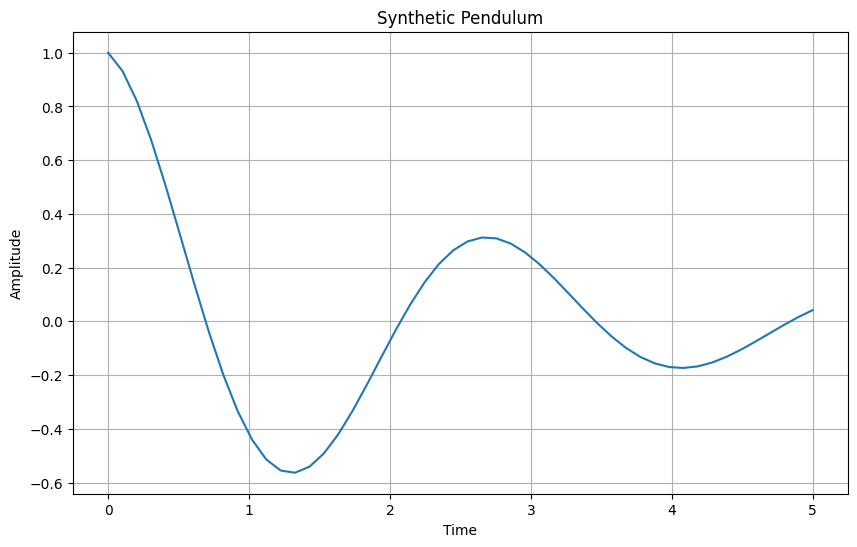

In [336]:
kapa_range = (3.0, 8.0)
b_range = (0.1, 1.0)
kapa = np.random.uniform(*kapa_range)
b = np.random.uniform(*b_range)
pemdulum1 = data_synthetic_pendulum(kapa, b)
plot_synthetic_pendulum(pemdulum1)

In [337]:
def build_dataset(num_samples=1000, kapa_range=(3.0, 8.0), b_range=(0.1, 1.0), maxtime=5.0, timesteps=50):
    observations = []
    questions = []
    params = []
    a_corr = []
    for _ in range(num_samples):
        # Build observations
        kapa = np.random.uniform(*kapa_range)
        b = np.random.uniform(*b_range)
        params.append((kapa, b))
        timeserie = data_synthetic_pendulum(kapa, b, timesteps=timesteps, maxtime=maxtime)
        observations.append(timeserie)
        # Build questions
        question = np.random.uniform(timesteps, timesteps*2)
        questions.append(question)
        # Build answer to the question
        a_corr.append(data_synthetic_pendulum(kapa, b, t=np.array(question), maxtime=maxtime, timesteps=50))
    return np.array(observations), np.array(questions), np.array(a_corr), np.array(params)

In [338]:
class PendulumDataset(Dataset):
    def __init__(self, observations, questions, answers, params):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.questions = torch.tensor(questions, dtype=torch.float32)
        self.answers = torch.tensor(answers, dtype=torch.float32)
        self.params = torch.tensor(params, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.questions[idx], self.answers[idx], self.params[idx]

In [339]:
N_samples = 10000
kapa_range = (3.0, 8.0)
b_range = (0.1, 1.0)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

dataset = PendulumDataset(observations, questions, answers, params)

In [340]:
train_valid_rate = 0.8
train_size = int(train_valid_rate * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

## 2. Create SciNet

In [341]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

In [342]:
# Test Encoder
batch_size = 10
input_size = 50
latent_size = 3
hidden_sizes = [128, 64]

x = torch.randn((batch_size, input_size))
encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=hidden_sizes)
mean, logvar = encoder(x)

assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

In [343]:
class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1, 
                 output_size: int = 1, 
                 hidden_sizes: list = [64, 32]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z

In [344]:
# Test Decoder
batch_size = 10
latent_size = 3
question_size = 1
hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, latent_size))
question = torch.randn((batch_size, question_size))
decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=hidden_sizes)
possible_answer = decoder(x, question)

assert possible_answer.shape == (batch_size, output_size)

In [345]:
class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 50, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1,
                 dec_hidden_sizes: list[int] = [64, 32], 
                 output_size: int = 1
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

In [346]:
# Test PendulumNet

batch_size = 10
input_size
enc_hidden_sizes = [128, 64]
latent_size = 3
question_size = 1
dec_hidden_sizes = [64, 32]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

assert possible_answer.shape == (batch_size, output_size)
assert mean.shape == (batch_size, latent_size)
assert logvar.shape == (batch_size, latent_size)

In [347]:
def scinet_loss(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.0
        ) -> torch.Tensor:
    prediction_loss = nn.MSELoss(reduction='none')(possible_answer, a_corr)
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).unsqueeze(-1)
    total_loss = prediction_loss + beta * kld_loss
    return torch.mean(total_loss)

In [348]:
# Test loss function

batch_size = 10
input_size
enc_hidden_sizes = [500, 100]
latent_size = 3
question_size = 1
dec_hidden_sizes = [100, 100]
output_size = 1

x = torch.randn((batch_size, input_size))
question = torch.randn((batch_size, question_size))
model = PendulumNet(input_size=input_size, enc_hidden_sizes=enc_hidden_sizes, latent_size=latent_size, question_size=question_size, dec_hidden_sizes=dec_hidden_sizes, output_size=output_size)
possible_answer, mean, logvar = model(x, question)

a_corr = torch.randn((batch_size, output_size))
beta = 2.0
loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta)

assert loss.shape == ()

## 3. Training loop

In [349]:
from magnetics_diagnostic_analysis.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [350]:
# Params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
batch_size1 = 512
batch_size2 = 512

m_input_size = 50
m_enc_hidden_sizes = [500, 100]
m_latent_size = 3
m_question_size = 1
m_dec_hidden_sizes = [100, 100]
m_output_size = 1

learning_rate = 1e-3
num_epochs = 150
kld_beta = 0.001
es_patience = 10
es_min_delta = 1e-4
gc_max_grad_norm = 1.0
lrs_factor = 0.66
lrs_patience = 4
lrs_min_lr = 1e-5
lrs_min_delta = 1e-4

Using device: cuda


In [351]:
train_loader = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size2, shuffle=False)

In [352]:
pendulum_net = PendulumNet(
    input_size=m_input_size, 
    enc_hidden_sizes=m_enc_hidden_sizes, 
    latent_size=m_latent_size, 
    question_size=m_question_size, 
    dec_hidden_sizes=m_dec_hidden_sizes, 
    output_size=m_output_size
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
gradient_clipper = GradientClipping(max_norm=gc_max_grad_norm)
lr_scheduler = LRScheduling(optimizer, factor=lrs_factor, patience=lrs_patience, min_lr=lrs_min_lr, min_delta=lrs_min_delta)

In [ ]:
# Training loop

def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:
    
    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20}{'Train Loss':<15}{'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for observations, questions, a_corr, _ in tqdm(train_loader, desc="Training", leave=False):
            observations = observations.to(device)
            questions = questions.to(device).unsqueeze(-1)
            a_corr = a_corr.to(device).unsqueeze(-1)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, a_corr, _ in tqdm(valid_loader, desc="Validation", leave=False):
                observations = observations.to(device)
                questions = questions.to(device).unsqueeze(-1)
                a_corr = a_corr.to(device).unsqueeze(-1)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss(possible_answer, a_corr, mean, logvar, beta=kld_beta)
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}{train_loss:<15.6f}{valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = Path().absolute() / 'pendulum_scinet.pth'
        torch.save(model.state_dict(), path)
    
    return history

In [354]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=num_epochs, 
    kld_beta=kld_beta, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler
)

------training on cpu-------

Epoch               Train Loss     Valid Loss     


1/150               68.507315      68.691441      


2/150               68.453143      68.676421      


3/150               68.509623      68.658954      


4/150               68.505916      68.724586      


5/150               68.489162      68.724666      


6/150               68.484489      68.726121      


7/150               68.531342      68.728022      
Reduced learning rate from 1.00e-03 to 6.60e-04


8/150               68.509231      68.732096      


9/150               68.493796      68.726365      


10/150              68.506361      68.722595      


11/150              68.474474      68.655693      


12/150              68.491868      68.677054      


13/150              68.502736      68.711567      


14/150              68.476855      68.713979      


15/150              68.526748      68.677160      
Reduced learning rate from 6.60e-04 to 4.36e-04


16/150              68.507953      68.725162      


17/150              68.486618      68.721626      


18/150              68.496713      68.716178      


19/150              68.508076      68.690498      
Reduced learning rate from 4.36e-04 to 2.87e-04


20/150              68.508055      68.668433      


21/150              68.505739      68.717188      


22/150              68.484190      68.681729      


23/150              68.474691      68.768598      
Reduced learning rate from 2.87e-04 to 1.90e-04


24/150              68.506878      68.730052      


25/150              68.477220      68.735674      


26/150              68.506791      68.673056      


27/150              68.509140      68.665218      
Reduced learning rate from 1.90e-04 to 1.25e-04


28/150              68.511765      68.748376      


29/150              68.514106      68.702393      


30/150              68.515063      68.775492      


31/150              68.487740      68.723809      
Reduced learning rate from 1.25e-04 to 8.27e-05


32/150              68.486534      68.651601      


33/150              68.483427      68.760532      


34/150              68.505177      68.684008      


35/150              68.523263      68.719734      


36/150              68.481556      68.724843      
Reduced learning rate from 8.27e-05 to 5.46e-05


37/150              68.493448      68.752489      


38/150              68.496969      68.724356      


39/150              68.503931      68.743146      


40/150              68.509671      68.710503      
Reduced learning rate from 5.46e-05 to 3.60e-05


41/150              68.512011      68.697842      


42/150              68.494908      68.692519      


43/150              68.527609      68.678270      


44/150              68.524228      68.719839      
Reduced learning rate from 3.60e-05 to 2.38e-05


45/150              68.518774      68.699322      


46/150              68.487073      68.699219      


47/150              68.528633      68.716422      


48/150              68.485455      68.701615      
Reduced learning rate from 2.38e-05 to 1.57e-05


49/150              68.508482      68.774576      


50/150              68.476695      68.696228      


51/150              68.478159      68.711321      


52/150              68.518093      68.633479      


53/150              68.511298      68.737207      


54/150              68.498019      68.741892      


55/150              68.515289      68.663135      


56/150              68.485858      68.745129      
Reduced learning rate from 1.57e-05 to 1.04e-05


57/150              68.520191      68.694893      


58/150              68.522776      68.738078      


59/150              68.488446      68.732161      


60/150              68.487451      68.719606      
Reduced learning rate from 1.04e-05 to 1.00e-05


61/150              68.508209      68.683895      


62/150              68.493148      68.702078      


63/150              68.488713      68.679449      


64/150              68.514932      68.702567      


65/150              68.501594      68.691846      


66/150              68.493550      68.702509      


67/150              68.469586      68.742379      


68/150              68.495703      68.636936      


69/150              68.512887      68.697663      


70/150              68.504025      68.710377      


71/150              68.498413      68.699284      


72/150              68.458017      68.717715      


73/150              68.522302      68.690672      


74/150              68.530430      68.681927      


75/150              68.511714      68.734191      


76/150              68.511138      68.737621      


77/150              68.517862      68.692016      


78/150              68.512937      68.747162      


79/150              68.476843      68.692158      


80/150              68.495061      68.667649      


81/150              68.503064      68.729194      


82/150              68.490936      68.634548      


83/150              68.493655      68.714263      


84/150              68.484073      68.707499      


85/150              68.486120      68.716049      


86/150              68.489336      68.689966      


87/150              68.510760      68.704074      


88/150              68.502977      68.742968      


89/150              68.515247      68.716536      


90/150              68.513727      68.649762      


91/150              68.525095      68.699495      


92/150              68.495876      68.682872      


93/150              68.526254      68.708922      


94/150              68.508639      68.759605      


95/150              68.520937      68.703415      


96/150              68.515639      68.712220      


97/150              68.518218      68.677675      


98/150              68.534572      68.697437      


99/150              68.492028      68.686973      


100/150             68.485284      68.666422      


101/150             68.487442      68.699015      


102/150             68.504338      68.707713      


103/150             68.502235      68.696387      


104/150             68.528879      68.688888      


105/150             68.503884      68.710455      


106/150             68.499222      68.692424      


107/150             68.511532      68.662779      


108/150             68.506062      68.675190      


109/150             68.501139      68.764673      


110/150             68.508594      68.705402      


111/150             68.505482      68.719674      


112/150             68.504562      68.678599      


113/150             68.486783      68.689708      


114/150             68.507111      68.757351      


115/150             68.511207      68.677969      


116/150             68.504851      68.722553      


117/150             68.507419      68.681147      


118/150             68.501395      68.726380      


119/150             68.492348      68.756862      


120/150             68.521498      68.768048      


121/150             68.504502      68.725847      


122/150             68.517856      68.796215      


123/150             68.491605      68.738032      


124/150             68.550789      68.684635      


125/150             68.520604      68.729692      


126/150             68.493415      68.682679      


127/150             68.494854      68.773789      


128/150             68.513954      68.747687      


129/150             68.498076      68.726371      


130/150             68.477968      68.760086      


131/150             68.510540      68.696837      


132/150             68.507208      68.665344      


133/150             68.492676      68.708119      


134/150             68.502243      68.684862      


135/150             68.490829      68.658520      


136/150             68.519080      68.668766      


137/150             68.500815      68.651024      


138/150             68.490495      68.700121      


139/150             68.479205      68.689422      


140/150             68.494746      68.728812      


141/150             68.522692      68.653674      


142/150             68.499062      68.700944      


143/150             68.472029      68.680142      


144/150             68.483098      68.721205      


145/150             68.495155      68.714961      


146/150             68.513783      68.669634      


147/150             68.525432      68.731639      


148/150             68.473000      68.732226      


149/150             68.519110      68.765012      


150/150             68.472031      68.708559      


In [361]:
path = Path().absolute() / 'pendulum_scinet.pth'
torch.save(pendulum_net.state_dict(), path)

In [362]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    #path = Path(__file__).absolute().parent.parent.parent.parent / "results/figures/mscred/last_training_history.png"
    #plt.savefig(path)
    plt.show()
    return None

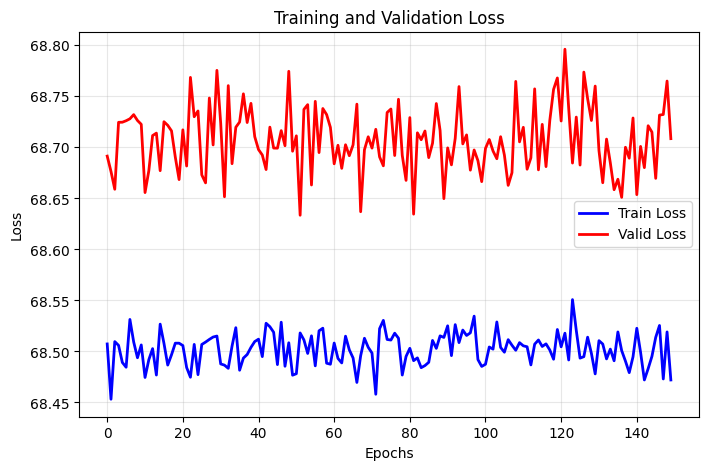

In [363]:
plot_history(history['train_loss'], history['valid_loss'])

## 4. Test on one example

In [358]:
def make_prediction(model: nn.Module, observation: np.array, question: float, device: torch.device = torch.device('cpu')) -> float:
    model.to(device).eval()
    observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
    question_tensor = torch.tensor([[question]], dtype=torch.float32).to(device)
    with torch.no_grad():
        possible_answer, _, _ = model(observation_tensor, question_tensor)
    return possible_answer.item()

In [359]:
def plot_prediction(observations, questions, answers, possible_answers) -> None:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(observations[0], label='Observation', color='blue')
    plt.scatter([questions[0]], [possible_answers[0]], color='red', label='Prediction', zorder=5)
    plt.scatter([questions[0]], [answers[0]], color='green', label='True Answer', zorder=5)
    plt.title('Pendulum Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()
    return None

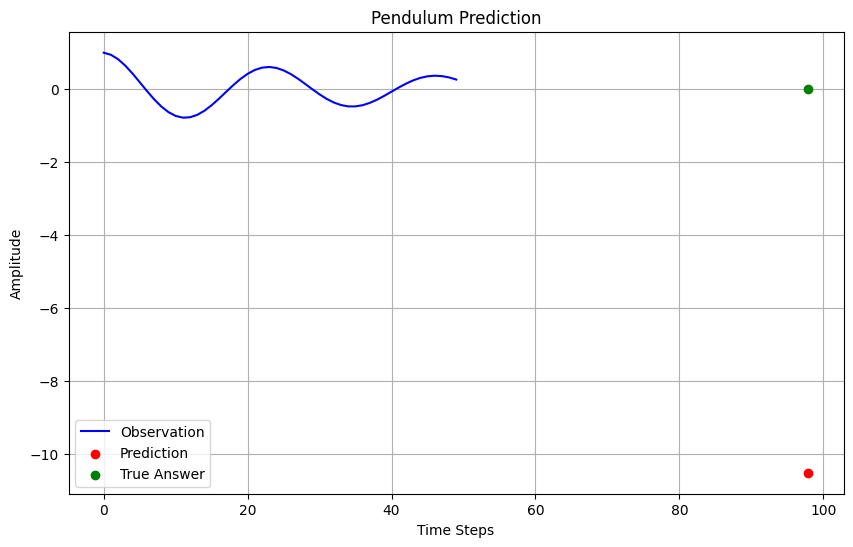

In [364]:
N_samples = 1
kapa_range = (2.0, 8.0)
b_range = (0.1, 1.0)
observations, questions, answers, params = build_dataset(N_samples, kapa_range, b_range)

possible_answer = make_prediction(pendulum_net, observations[0], questions[0], device=device)
plot_prediction(observations, questions, answers, [possible_answer])